In [1]:
! pip install xarray cfgrib eccodes --quiet

/bin/bash: line 1: pip: command not found


In [6]:
!uv add kagglehub

Resolved 295 packages in 14ms
Audited 290 packages in 252ms


In [2]:
import duckdb
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMapWithTime

from sklearn.neighbors import BallTree

pd.set_option('display.max_columns', None)

In [10]:
con = duckdb.connect('/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/data/iNaturalist.duckdb')
print("connected!")

connected!


In [4]:
# TimesFM imports
import numpy as np
import torch
from torch.nn.functional import normalize
from transformers import TimesFmModelForPrediction

/network/scratch/b/balik/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

/network/scratch/b/balik/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 780k/780k [00:00<00:00, 8.00MB/s]

Extracting files...
Path to dataset files: /home/mila/b/balik/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1


In [3]:
# Load the kc_house dataset
path = "/network/scratch/b/balik/COMP-685-Fall-2025/data/housesalesprediction/versions/1"
kc_house = pd.read_csv(f"{path}/kc_house_data.csv")
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
kc_house["date"] = pd.to_datetime(kc_house["date"], format="%Y%m%dT%H%M%S")
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
kc_house["date"] = pd.to_datetime(kc_house["date"])

year_replacements = {2013: 2020, 2014: 2021, 2015: 2022, 2016: 2023}

kc_house['date'] = kc_house['date'].apply(lambda x: x.replace(year=year_replacements.get(x.year, x.year)))
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2021-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2021-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2022-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2021-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2022-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
duckdb.sql("CREATE TABLE kc_house AS SELECT * FROM kc_house")
#duckdb.sql("""DROP TABLE kc_house""")

In [7]:
tables_query = duckdb.sql("SHOW ALL TABLES")
print(tables_query.df())

  database schema      name  \
0   memory   main  kc_house   

                                        column_names  \
0  [id, date, price, bedrooms, bathrooms, sqft_li...   

                                        column_types  temporary  
0  [BIGINT, TIMESTAMP_NS, DOUBLE, BIGINT, DOUBLE,...      False  


In [11]:
#min_date = "2020-01-01"
#max_date = "2025-12-31"

query = f"""
-- This can be grouped further
SELECT *
FROM ERA5_grid;
"""
df_ERA5_grid = con.execute(query).df()
# Remove a few of the first days that don't have 7-days histories (I didn't get 2019 data)
df_ERA5_grid

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [12]:
query = """
WITH kc_house_coordinates AS (
    SELECT DISTINCT id, lat, long
    FROM kc_house
)
SELECT *
FROM kc_house_coordinates
"""
kc_house_coordinates = con.execute(query).df()
kc_house_coordinates

,id,lat,long
0,2426039314,47.7274,-122.357
1,2768000400,47.6702,-122.362
2,3626039271,47.6989,-122.369
3,9478500640,47.3663,-122.114
4,9558200045,47.4366,-122.335
...,...,...,...
21431,6664500090,47.4832,-122.145
21432,524059330,47.5990,-122.197
21433,9578500790,47.2974,-122.349
21434,844000965,47.3095,-122.002


In [13]:
query = """
SELECT latitude, longitude, grid_id
FROM era5_grid
ORDER BY latitude, longitude
"""
era5_grid = con.execute(query).df()
era5_grid

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [14]:
# Convert degrees to radians
kc_house_coords = np.radians(kc_house_coordinates[['lat', 'long']])
era5_coords = np.radians(era5_grid[['latitude', 'longitude']])

# Build BallTree using Haversine metric (expects radians)
print("Building BallTree")
tree = BallTree(era5_coords, metric='haversine')

# Query nearest neighbor (returns distance in radians)
print("Query nearest neighbor in kc_house_coords")
distances, indices = tree.query(kc_house_coords, k=1)

# Get nearest grid_id for each kc_house point
print("Get nearest grid_id")
nearest_grid_ids = era5_grid.iloc[indices.flatten()]['grid_id'].values

# Add nearest_grid_id column
kc_house_coordinates['nearest_grid_id'] = nearest_grid_ids

# Convert Haversine distance to km
earth_radius_km = 6371
kc_house_coordinates['distance_km'] = distances.flatten() * earth_radius_km
kc_house_coordinates.head()

Building BallTree
Query nearest neighbor in kc_house_coords
Get nearest grid_id


,id,lat,long,nearest_grid_id,distance_km
0,2426039314,47.7274,-122.357,794391,8.386809
1,2768000400,47.6702,-122.362,794391,12.204922
2,3626039271,47.6989,-122.369,794391,10.560215
3,9478500640,47.3663,-122.114,791512,15.527807
4,9558200045,47.4366,-122.335,792951,9.514278


In [15]:
# number of unique grid ids matched
kc_house_coordinates["nearest_grid_id"].nunique()

15

In [16]:
# Create the grid table in DuckDB
kc_house_grid_mapping = duckdb.execute("CREATE TABLE IF NOT EXISTS kc_house_grid_mapping AS SELECT * FROM kc_house_coordinates")
print("Table 'kc_house_grid_mapping' created successfully!")
kc_house_grid_mapping = duckdb.execute("SELECT * FROM kc_house_grid_mapping").df()

Table 'kc_house_grid_mapping' created successfully!


In [17]:
min_date = "2020-01-01"
max_date = "2025-12-31"

query = f"""
WITH filtered_kc_house AS (
    SELECT
        id,
        date AS dateOcurrence,  -- keep only the date part
        lat,
        long,
        price
    FROM kc_house
    WHERE
        lat IS NOT NULL
        AND long IS NOT NULL
        AND date IS NOT NULL 
        AND dateOcurrence IS NOT NULL
),

mapped_kc_house AS (
    SELECT
        CAST(filtered_kc_house.dateOcurrence AS DATE) AS dateOcurrence,
        filtered_kc_house.lat,
        filtered_kc_house.long,
        filtered_kc_house.price,
        kc_house_grid_mapping.nearest_grid_id,
    FROM filtered_kc_house AS filtered_kc_house
    JOIN kc_house_grid_mapping AS kc_house_grid_mapping
    USING (id)
),

mapped_ERA5 AS (
    SELECT
        CAST(ERA5_Daily.valid_time AS DATE) AS valid_time,
        ERA5_Daily.latitude,
        ERA5_Daily.longitude,
        ERA5_grid.grid_id,
        -- Build the array of 7 historical + current values (ordered by date)
        LIST(u10) OVER w AS u10_hist,
        LIST(v10) OVER w AS v10_hist,
        LIST(d2m) OVER w AS d2m_hist,
        LIST(t2m) OVER w AS t2m_hist,
        LIST(msl) OVER w AS msl_hist,
        LIST(mwd) OVER w AS mwd_hist,
        LIST(mwp) OVER w AS mwp_hist,
        LIST(sst) OVER w AS sst_hist,
        LIST(swh) OVER w AS swh_hist,
        LIST(sp)  OVER w AS sp_hist,
        LIST(tp)  OVER w AS tp_hist

    FROM ERA5_Daily
    JOIN ERA5_grid 
      ON ERA5_Daily.latitude = ERA5_grid.latitude
     AND ERA5_Daily.longitude = ERA5_grid.longitude
    WHERE
        valid_time BETWEEN '{min_date}' AND '{max_date}'
        AND ERA5_grid.grid_id IN (
            SELECT DISTINCT nearest_grid_id
            FROM mapped_kc_house
        )

    WINDOW w AS (
        PARTITION BY grid_id
        ORDER BY valid_time
        -- This gets the last 6 days before valid_time and the current valid_time
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    )
),

joined_kc_house_ERA5 AS (
    SELECT
        mapped_kc_house.dateOcurrence,
        mapped_kc_house.lat,
        mapped_kc_house.long,
        mapped_kc_house.price,
        mapped_kc_house.nearest_grid_id,
        mapped_ERA5.latitude AS nearest_grid_id_latitude,
        mapped_ERA5.longitude AS nearest_grid_id_longitude,
        mapped_ERA5.u10_hist,
        mapped_ERA5.v10_hist,
        mapped_ERA5.d2m_hist,
        mapped_ERA5.t2m_hist,
        mapped_ERA5.msl_hist,
        -- mapped_ERA5.mwd_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.mwp_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.sst_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.swh_hist, -- these are sea variables, so they appear as NaN on the land
        mapped_ERA5.sp_hist,
        mapped_ERA5.tp_hist
    FROM mapped_kc_house AS mapped_kc_house
    JOIN mapped_ERA5 AS mapped_ERA5
      ON mapped_kc_house.nearest_grid_id = mapped_ERA5.grid_id
      AND mapped_kc_house.dateOcurrence = mapped_ERA5.valid_time
)

-- This can be grouped further
SELECT *
FROM joined_kc_house_ERA5
ORDER BY dateOcurrence, lat, long;
"""
#result = con.sql(query).fetchdf()

df = con.execute(query).df()
df = df[df["u10_hist"].apply(len) == 7]
df


,dateOcurrence,lat,long,price,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2021-05-02,47.2617,-122.190,400000.0,791511,47.25,237.75,"[0.8870461583137512, 1.2899411916732788, 0.676...","[1.3675588369369507, 1.4046701192855835, 0.746...","[279.24566650390625, 277.9954528808594, 278.70...","[282.13775634765625, 283.2629089355469, 283.95...","[101005.1484375, 101853.34375, 102432.6640625,...","[98097.5, 98937.2734375, 99524.0859375, 99504....","[6.26842156634666e-05, 2.980232238769531e-07, ..."
1,2021-05-02,47.2703,-122.069,491500.0,791512,47.25,238.00,"[0.9030780792236328, 1.0777015686035156, 0.354...","[0.8162078857421875, 0.7934233546257019, 0.495...","[278.1727600097656, 276.4789123535156, 277.728...","[281.25518798828125, 282.2860107421875, 283.42...","[101032.4140625, 101868.3203125, 102439.28125,...","[96202.1640625, 97023.3125, 97603.4140625, 975...","[8.857250213623047e-05, 7.549921861027542e-07,..."
2,2021-05-02,47.3256,-122.378,604000.0,791510,47.25,237.50,"[1.0660825967788696, 1.5811601877212524, 0.958...","[1.7548471689224243, 1.8143787384033203, 0.863...","[279.9477233886719, 279.2127380371094, 279.577...","[283.5152893066406, 284.3341064453125, 284.943...","[100995.4765625, 101857.375, 102440.53125, 102...","[100393.125, 101251.0234375, 101834.0546875, 1...","[2.7974447220913135e-05, 5.364418029785156e-07..."
3,2021-05-02,47.3279,-122.191,367500.0,791511,47.25,237.75,"[0.8870461583137512, 1.2899411916732788, 0.676...","[1.3675588369369507, 1.4046701192855835, 0.746...","[279.24566650390625, 277.9954528808594, 278.70...","[282.13775634765625, 283.2629089355469, 283.95...","[101005.1484375, 101853.34375, 102432.6640625,...","[98097.5, 98937.2734375, 99524.0859375, 99504....","[6.26842156634666e-05, 2.980232238769531e-07, ..."
4,2021-05-02,47.3358,-122.055,300000.0,791512,47.25,238.00,"[0.9030780792236328, 1.0777015686035156, 0.354...","[0.8162078857421875, 0.7934233546257019, 0.495...","[278.1727600097656, 276.4789123535156, 277.728...","[281.25518798828125, 282.2860107421875, 283.42...","[101032.4140625, 101868.3203125, 102439.28125,...","[96202.1640625, 97023.3125, 97603.4140625, 975...","[8.857250213623047e-05, 7.549921861027542e-07,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2022-05-14,47.6854,-122.331,855000.0,794391,47.75,237.75,"[0.26189103722572327, 0.269024521112442, 0.023...","[1.6448841094970703, 1.1482830047607422, 1.835...","[276.47314453125, 276.6854248046875, 277.72094...","[280.9006042480469, 281.9074401855469, 282.423...","[100932.5, 101038.0390625, 101920.1796875, 102...","[100256.78125, 100364.28125, 101241.5859375, 1...","[0.00024330615997314453, 6.506840145448223e-05..."
21609,2022-05-14,47.7052,-122.343,359000.0,794391,47.75,237.75,"[0.26189103722572327, 0.269024521112442, 0.023...","[1.6448841094970703, 1.1482830047607422, 1.835...","[276.47314453125, 276.6854248046875, 277.72094...","[280.9006042480469, 281.9074401855469, 282.423...","[100932.5, 101038.0390625, 101920.1796875, 102...","[100256.78125, 100364.28125, 101241.5859375, 1...","[0.00024330615997314453, 6.506840145448223e-05..."
21610,2022-05-15,47.5951,-122.144,450000.0,792951,47.50,237.75,"[0.9422829747200012, 1.0147966146469116, 0.753...","[1.6568279266357422, 2.387666702270508, 2.0147...","[277.0401611328125, 277.339599609375, 276.9050...","[282.0155334472656, 282.9573669433594, 284.047...","[101042.2890625, 101928.09375, 102323.8125, 10...","[100122.78125, 101002.125, 101400.5859375, 100...","[0.00010196367657044902, 0.0002252856938866898..."
21611,2022-05-24,47.6914,-122.308,445500.0,794391,47.75,237.75,"[0.08604177087545395, 0.5530338287353516, 0.06...","[4.240194797515869, 1.5164750814437866, -0.935...","[279.3968200683594, 277.7798767089844, 278.186...","[284.6313781738281, 282.7490539550781, 283.344...","[101846.375, 102094.125, 102444.8203125, 10225...","[101175.2421875, 101412.9375, 101766.3515625, ...","[0.0003275

# Data

## KC-House joined with ERA5
The idea is that for a given observation with (latitude, longitude, time) we can join this with the ERA5 dataset to get relevant climate features for that specific place and time. 


These are the variables in the ERA5 dataset

```python
era5_variable_names = {
    "u10": "10m u-component of wind",
    "v10": "10m v-component of wind",
    "d2m": "2m dewpoint temperature",
    "t2m": "2m temperature",
    "msl": "Mean sea level pressure",
    "mwd": "Mean wave direction",
    "mwp": "Mean wave period",
    "sst": "Sea surface temperature",
    "swh": "Significant height of combined wind waves and swell",
    "sp": "Surface pressure",
    "tp": "Total precipitation"
}
```

### Daily Aggregation



#### Aggregating by `dateOcurrence` and `nearest_grid_id`

We can group the data by `dateOcurrence` and `nearest_grid_id` to keep a daily resolution while combining all observations within the same grid cell into a single aggregated record.

In [18]:
cols = [
    "dateOcurrence",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "lat",
    "long",
    "price",
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

# Sort so that "most recent" means "last" in each group
df = df.sort_values("dateOcurrence")

agg_df = (
    df.groupby(["dateOcurrence", "nearest_grid_id"], as_index=False)
      .agg({
          "price": "mean",
          "lat": list,
          "long": list,
          "nearest_grid_id_latitude": "last",
          "nearest_grid_id_longitude": "last",
          "u10_hist": "last",
          "v10_hist": "last",
          "d2m_hist": "last",
          "t2m_hist": "last",
          "msl_hist": "last",
          "sp_hist": "last",
          "tp_hist": "last",
      })
)
agg_df = agg_df[cols]
agg_df


,dateOcurrence,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,lat,long,price,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2021-05-02,791510,47.25,237.50,[47.3256],[-122.378],6.040000e+05,"[1.0660825967788696, 1.5811601877212524, 0.958...","[1.7548471689224243, 1.8143787384033203, 0.863...","[279.9477233886719, 279.2127380371094, 279.577...","[283.5152893066406, 284.3341064453125, 284.943...","[100995.4765625, 101857.375, 102440.53125, 102...","[100393.125, 101251.0234375, 101834.0546875, 1...","[2.7974447220913135e-05, 5.364418029785156e-07..."
1,2021-05-02,791511,47.25,237.75,"[47.2617, 47.3279, 47.3406, 47.3537, 47.3672]","[-122.19, -122.191, -122.269, -122.303, -122.151]",3.359000e+05,"[0.8870461583137512, 1.2899411916732788, 0.676...","[1.3675588369369507, 1.4046701192855835, 0.746...","[279.24566650390625, 277.9954528808594, 278.70...","[282.13775634765625, 283.2629089355469, 283.95...","[101005.1484375, 101853.34375, 102432.6640625,...","[98097.5, 98937.2734375, 99524.0859375, 99504....","[6.26842156634666e-05, 2.980232238769531e-07, ..."
2,2021-05-02,791512,47.25,238.00,"[47.2703, 47.3358, 47.3493]","[-122.069, -122.055, -122.034]",3.595667e+05,"[0.9030780792236328, 1.0777015686035156, 0.354...","[0.8162078857421875, 0.7934233546257019, 0.495...","[278.1727600097656, 276.4789123535156, 277.728...","[281.25518798828125, 282.2860107421875, 283.42...","[101032.4140625, 101868.3203125, 102439.28125,...","[96202.1640625, 97023.3125, 97603.4140625, 975...","[8.857250213623047e-05, 7.549921861027542e-07,..."
3,2021-05-02,792950,47.50,237.50,"[47.5714, 47.5631, 47.5274]","[-122.408, -122.397, -122.384]",6.016500e+05,"[0.2697772979736328, 0.6537920832633972, 0.167...","[1.3557993173599243, 1.5795968770980835, 0.765...","[279.79132080078125, 279.3146057128906, 279.92...","[283.62921142578125, 284.3424072265625, 284.94...","[100977.8515625, 101833.90625, 102432.4140625,...","[100344.6640625, 101197.0625, 101794.3828125, ...","[2.3245811462402344e-05, 1.7881393432617188e-0..."
4,2021-05-02,792951,47.50,237.75,"[47.6022, 47.5746, 47.3815, 47.4225, 47.4419, ...","[-122.134, -122.135, -122.313, -122.153, -122....",3.491625e+05,"[0.4311135709285736, 0.722802460193634, 0.3709...","[1.4507293701171875, 1.5619373321533203, 0.772...","[279.74102783203125, 278.9466247558594, 279.59...","[283.49615478515625, 284.0940246582031, 285.11...","[100992.1015625, 101844.875, 102437.40625, 102...","[100079.4140625, 100928.2265625, 101520.96875,...","[3.1312305509345606e-05, 8.145968308781448e-07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,2022-05-14,792952,47.50,238.00,[47.5322],[-122.075],7.499500e+05,"[1.1016534566879272, 0.9091612696647644, 0.884...","[1.7153186798095703, 1.2904542684555054, 1.838...","[275.275634765625, 276.0587158203125, 276.3649...","[280.01031494140625, 280.6041564941406, 281.54...","[100974.34375, 101073.3984375, 101963.09375, 1...","[98209.5703125, 98317.03125, 99188.5, 99574.71...","[0.00018207232642453164, 0.0001746217458276078..."
2742,2022-05-14,794391,47.75,237.75,"[47.6854, 47.6542, 47.7052]","[-122.331, -122.331, -122.343]",9.696667e+05,"[0.26189103722572327, 0.269024521112442, 0.023...","[1.6448841094970703, 1.1482830047607422, 1.835...","[276.47314453125, 276.6854248046875, 277.72094...","[280.9006042480469, 281.9074401855469, 282.423...","[100932.5, 101038.0390625, 101920.1796875, 102...","[100256.78125, 100364.28125, 101241.5859375, 1...","[0.00024330615997314453, 6.506840145448223e-05..."
2743,2022-05-15,792951,47.50,237.75,[47.5951],[-122.144],4.500000e+05,"[0.9422829747200012, 1.0147966146469116, 0.753...","[1.6568279266357422, 2.387666702270508, 2.0147...","[277.0401611328125, 277.339599609375, 276.9050...","[282.0155334472656, 282.9573669433594, 284.047...","[101042.2890625, 101928.09375, 102323.8125, 10...","[100122.78125, 101002.125, 101400.5859375, 100...","[0.00010196367657044902, 0.0002252856938866898..."
2744,2022-05-24,794391,47.75,237.75,[

#### Aggregating by `year_week` and `nearest_grid_id`

We can group the data by `year_week` and `nearest_grid_id` to produce weekly aggregated records, combining all observations within the same grid cell for each week.

In [19]:
cols = [
    "year_week",
    "dateOcurrence",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "lat",
    "long",
    "price",
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

df["dateOcurrence"] = pd.to_datetime(df["dateOcurrence"])

# Create a week-of-year column
iso = df["dateOcurrence"].dt.isocalendar()
df["year_week"] = iso["year"].astype(str) + "-" + iso["week"].astype(str).str.zfill(2)


# Sort so that "most recent" means "last" in each group
df = df.sort_values("dateOcurrence")

agg_df = (
    df
    .groupby(["year_week", "nearest_grid_id"], as_index=False)
    .agg({
          "price": "mean",
          "dateOcurrence": list,
          "lat": list,
          "long": list,
          "nearest_grid_id_latitude": "last",
          "nearest_grid_id_longitude": "last",
          "u10_hist": "last",
          "v10_hist": "last",
          "d2m_hist": "last",
          "t2m_hist": "last",
          "msl_hist": "last",
          "sp_hist": "last",
          "tp_hist": "last",
      }
    )
)
agg_df = agg_df[cols]
agg_df

,year_week,dateOcurrence,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,lat,long,price,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2021-17,[2021-05-02 00:00:00],791510,47.25,237.50,[47.3256],[-122.378],604000.000000,"[1.0660825967788696, 1.5811601877212524, 0.958...","[1.7548471689224243, 1.8143787384033203, 0.863...","[279.9477233886719, 279.2127380371094, 279.577...","[283.5152893066406, 284.3341064453125, 284.943...","[100995.4765625, 101857.375, 102440.53125, 102...","[100393.125, 101251.0234375, 101834.0546875, 1...","[2.7974447220913135e-05, 5.364418029785156e-07..."
1,2021-17,"[2021-05-02 00:00:00, 2021-05-02 00:00:00, 202...",791511,47.25,237.75,"[47.2617, 47.3279, 47.3406, 47.3537, 47.3672]","[-122.19, -122.191, -122.269, -122.303, -122.151]",335900.000000,"[0.8870461583137512, 1.2899411916732788, 0.676...","[1.3675588369369507, 1.4046701192855835, 0.746...","[279.24566650390625, 277.9954528808594, 278.70...","[282.13775634765625, 283.2629089355469, 283.95...","[101005.1484375, 101853.34375, 102432.6640625,...","[98097.5, 98937.2734375, 99524.0859375, 99504....","[6.26842156634666e-05, 2.980232238769531e-07, ..."
2,2021-17,"[2021-05-02 00:00:00, 2021-05-02 00:00:00, 202...",791512,47.25,238.00,"[47.3358, 47.3493, 47.2703]","[-122.055, -122.034, -122.069]",359566.666667,"[0.9030780792236328, 1.0777015686035156, 0.354...","[0.8162078857421875, 0.7934233546257019, 0.495...","[278.1727600097656, 276.4789123535156, 277.728...","[281.25518798828125, 282.2860107421875, 283.42...","[101032.4140625, 101868.3203125, 102439.28125,...","[96202.1640625, 97023.3125, 97603.4140625, 975...","[8.857250213623047e-05, 7.549921861027542e-07,..."
3,2021-17,"[2021-05-02 00:00:00, 2021-05-02 00:00:00, 202...",792950,47.50,237.50,"[47.5714, 47.5631, 47.5274]","[-122.408, -122.397, -122.384]",601650.000000,"[0.2697772979736328, 0.6537920832633972, 0.167...","[1.3557993173599243, 1.5795968770980835, 0.765...","[279.79132080078125, 279.3146057128906, 279.92...","[283.62921142578125, 284.3424072265625, 284.94...","[100977.8515625, 101833.90625, 102432.4140625,...","[100344.6640625, 101197.0625, 101794.3828125, ...","[2.3245811462402344e-05, 1.7881393432617188e-0..."
4,2021-17,"[2021-05-02 00:00:00, 2021-05-02 00:00:00, 202...",792951,47.50,237.75,"[47.3815, 47.4225, 47.4419, 47.462, 47.5725, 4...","[-122.313, -122.153, -122.34, -122.193, -122.1...",349162.500000,"[0.4311135709285736, 0.722802460193634, 0.3709...","[1.4507293701171875, 1.5619373321533203, 0.772...","[279.74102783203125, 278.9466247558594, 279.59...","[283.49615478515625, 284.0940246582031, 285.11...","[100992.1015625, 101844.875, 102437.40625, 102...","[100079.4140625, 100928.2265625, 101520.96875,...","[3.1312305509345606e-05, 8.145968308781448e-07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,2022-19,"[2022-05-10 00:00:00, 2022-05-12 00:00:00, 202...",792953,47.50,238.25,"[47.5416, 47.526, 47.4964, 47.4487]","[-121.864, -121.81, -121.771, -121.773]",411487.500000,"[-0.03613217547535896, 1.5667800903320312, 1.5...","[1.012168288230896, 0.8133964538574219, 0.8822...","[278.2337646484375, 277.9447326660156, 273.741...","[279.8530578613281, 279.9400939941406, 277.354...","[100770.4765625, 100733.0859375, 100980.09375,...","[93756.8046875, 93719.1328125, 93883.8984375, ...","[0.0005570650100708008, 0.0008657177095301449,..."
572,2022-19,[2022-05-09 00:00:00],794390,47.75,237.50,[47.6506],[-122.405],812000.000000,"[-0.8214251399040222, -0.30064329504966736, -0...","[1.3199087381362915, -0.5434627532958984, 1.88...","[281.1507873535156, 280.2704162597656, 280.609...","[284.1454162597656, 283.5526428222656, 283.938...","[102178.09375, 102044.9921875, 100864.2890625,...","[101783.25, 101651.1015625, 100474.9140625, 10...","[6.341934204101562e-05, 2.4259090423583984e-05..."
573,2022-19,"[2022-05-10 00:00:00, 2022-05-11 00:00:00, 202...",794391,47.75,237.75,"[47.7733, 47.6938, 47.691, 47.632, 47.6435, 47...","[-122.17, -122.

## SatCLIP embeddings

Let's use the aggregated dataframe by `year_week` and `nearest_grid_id`.

Provide coordinates in standard decimal degrees:
- Longitude: -180° to 180° or 0° to 360°, it transforms to radians internally
- Latitude: -90° to 90°
- SatCLIP expects (longitude, latitude)

See [B01 - Use SatCLIP embeddings to predict air temperatures](https://github.com/microsoft/satclip/blob/main/notebooks/B01_Example_Air_Temperature_Prediction.ipynb)

In [20]:
import sys
import os
satclip_path = "/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/Repositories/satclip/"

sys.path.append(satclip_path)
sys.path.insert(0, os.path.join(satclip_path, "satclip"))

In [21]:
import torch
from tqdm import tqdm

from huggingface_hub import hf_hub_download
from satclip.model import SatCLIP
from satclip.location_encoder import LocationEncoder
from load import get_satclip

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

/network/scratch/b/balik/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cpu


/network/scratch/b/balik/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [22]:
locations = torch.randn(32, 2)  # Represents a batch of 32 locations (lon/lat)

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)  # Only loads location encoder by default
model.eval()

using pretrained moco vit16


LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

In [20]:
coordinates = [
    [-10.0, 20.0],
    [350.0, 20.0]
]
coordinates = torch.tensor(coordinates, dtype=torch.float32)

# SatCLIP expects (longitude, latitude)
with torch.no_grad():
    embeddings = model(coordinates.double().to(device)).detach().cpu()

print(embeddings.shape)
embeddings[0][0:5], embeddings[1][0:5]

torch.Size([2, 256])


(tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64),
 tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64))

In [23]:
# Prepare data (lon, lat)
coords = agg_df[["nearest_grid_id_longitude", "nearest_grid_id_latitude"]].values
coords = torch.tensor(coords, dtype=torch.float32)

batch_size = 512
emb_list = []

with torch.no_grad():
    for i in tqdm(range(0, len(coords), batch_size)):
        batch = coords[i : i + batch_size]
        batch = batch.double().to(device)

        emb = model(batch).detach().cpu()
        emb_list.append(emb)

# Concatenate all batches
all_embeddings = torch.cat(emb_list, dim=0).numpy()
print(f"{all_embeddings.shape}")

# Add as new dataframe column
agg_df["satclip_embeddings"] = list(all_embeddings)

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

(576, 256)


In [24]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "price"
]

agg_df[columns]

,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,price
0,2021-17,791510,47.25,237.50,"[4.0904994386371625, 0.9948005035906876, -2.09...",604000.000000
1,2021-17,791511,47.25,237.75,"[4.182614929331582, 0.936547901328237, -1.6506...",335900.000000
2,2021-17,791512,47.25,238.00,"[4.280476683430049, 0.7677512805544202, -1.117...",359566.666667
3,2021-17,792950,47.50,237.50,"[4.355779377617795, 0.9553728233726735, -2.088...",601650.000000
4,2021-17,792951,47.50,237.75,"[4.43896860078291, 0.8933787987166651, -1.6899...",349162.500000
...,...,...,...,...,...,...
571,2022-19,792953,47.50,238.25,"[4.618678046975655, 0.4575673204035908, -0.687...",411487.500000
572,2022-19,794390,47.75,237.50,"[4.63264101560559, 0.8509159964486935, -1.9959...",812000.000000
573,2022-19,794391,47.75,237.75,"[4.699343077233216, 0.7757787355999315, -1.645...",575307.058824
574,2022-19,794392,47.75,238.00,"[4.769088883158696, 0.5955706750874894, -1.222...",770993.750000


# TimesFM


f(decimalLatitude, decimalLongitude, dateOcurrence, u10, v10,    d2m, ...) =  countOccurrences \approx population $, where the coordinates will pass through SatCLIP and the climate features (time series) will be encoded with a time encoder to pass as features to a predictor

In [ ]:
# # 1) Load a TimesFM checkpoint (univariate)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

In [ ]:
# #input_df = agg_df.copy().drop(columns=["countOccurrences"])
# #output_df = agg_df[["countOccurrences"]].copy()

# input_df = agg_df[["countOccurrences"]].copy()
# input_df = input_df.astype("float32").to_numpy()
# input_y = torch.tensor(input_df, dtype=torch.bfloat16, device=model.device)
# past_values = [input_y]

# freq_idx = 0
# freq_tensor = torch.tensor([freq_idx], dtype=torch.long, device=model.device)

In [ ]:
# # Build usable 1D numeric series from agg_df object-columns, then pass to TimesFM.
# # (Fixes the "numpy.object_" -> torch.tensor conversion error by converting each row element to numeric
# # arrays and concatenating / stacking into plain float arrays.)

# # 1) Load model (already imported above)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

# # helper: convert an agg_df column of 7-day lists (object dtype) into a single 1D float array
# def col_to_series(col, max_rows=None):
#     vals = agg_df[col].to_numpy()
#     if max_rows is not None:
#         vals = vals[:max_rows]
#     arrs = [np.asarray(v, dtype=float).ravel() for v in vals if v is not None]
#     if len(arrs) == 0:
#         return np.array([], dtype=float)
#     # concatenate rows to get a longer time series (you can change concatenation strategy)
#     return np.concatenate(arrs)

# # create a batch of variable-length series from the ERA5 history columns
# series_cols = ["u10_hist", "v10_hist", "t2m_hist", "msl_hist"]
# series = [col_to_series(c, max_rows=50) for c in series_cols]  # limit rows to avoid extremely long arrays

# # sanity check
# for i, s in enumerate(series):
#     print(f"{series_cols[i]} -> length {s.size}")

# # Convert to torch tensors (use float32 first to avoid object dtype issues), then move to model device and bfloat16
# past_values = []
# for s in series:
#     if s.size == 0:
#         raise ValueError("One of the series is empty; adjust col_to_series/max_rows or inspect agg_df.")
#     t = torch.tensor(s, dtype=torch.float32, device=model.device)
#     past_values.append(t.to(dtype=torch.bfloat16))

# # frequency vector
# freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# # forward pass
# with torch.no_grad():
#     out = model(
#         past_values=past_values,
#         freq=freq,
#         output_hidden_states=True,
#         return_dict=True,
#     )

# # pool valid timesteps for each series
# embeddings = []
# for i, ts in enumerate(past_values):
#     L = ts.shape[0]
#     vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
#     embeddings.append(vec)

# embeddings = torch.stack(embeddings, dim=0)
# embeddings = normalize(embeddings, p=2, dim=1)

# print("embeddings.shape =", embeddings.shape)

u10_hist -> length 350
v10_hist -> length 350
t2m_hist -> length 350
msl_hist -> length 350
embeddings.shape = torch.Size([4, 1280])


In [ ]:


# # 1) Load a TimesFM checkpoint (univariate)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

# # 2) Example batch of variable-length time series (replace with your data)
# series = [
#     np.sin(np.linspace(0, 20, 100)),   # length 100
#     np.sin(np.linspace(0, 20, 240)),   # length 240
#     np.sin(np.linspace(0, 20, 512)),   # length 512
#     np.sin(np.linspace(0, 20, 1024)),   # length 1024
# ]

# # Convert to tensors on the model's device
# past_values = [torch.tensor(x, dtype=torch.bfloat16, device=model.device) for x in series]

# # TimesFM uses a small frequency embedding; if you don't know it, you can set zeros.
# # Shape: (batch,)
# freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# # 3) Forward pass requesting hidden states
# with torch.no_grad():
#     out = model(
#         past_values=past_values,
#         freq=freq,
#         output_hidden_states=True,   # <— important
#         return_dict=True,
#     )

# # out.last_hidden_state: (batch, seq_len, hidden_size) after internal padding
# # We'll mean-pool over the *valid* timesteps for each series, then L2-normalize.

# embeddings = []
# for i, ts in enumerate(past_values):
#     L = ts.shape[0]  # original (unpadded) length
#     # slice to valid region, mean-pool over time
#     vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
#     embeddings.append(vec)

# embeddings = torch.stack(embeddings, dim=0)           # (batch, hidden_size)
# embeddings = normalize(embeddings, p=2, dim=1)        # cosine-friendly

# print(embeddings.shape)   # e.g., torch.Size([4, 1280]) for the 500M checkpoint

torch.Size([4, 1280])


### Chronos

In [25]:
import argparse
import warnings
from typing import Optional, Literal

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from chronos import ChronosPipeline, ChronosBoltPipeline

In [26]:
def pool_embeddings(
    embeddings: torch.Tensor,
    method: Literal["mean", "max", "last", "first", "cls"] = "mean"
) -> torch.Tensor:
    """
    Pool sequence embeddings into a single vector.
    
    Parameters
    ----------
    embeddings : torch.Tensor
        Embeddings of shape (batch_size, sequence_length, d_model)
    method : str
        Pooling method: 'mean', 'max', 'last', 'first', 'cls'
        - 'mean': Average over sequence dimension
        - 'max': Max pooling over sequence dimension
        - 'last': Take the last token embedding
        - 'first'/'cls': Take the first token embedding
        
    Returns
    -------
    torch.Tensor
        Pooled embeddings of shape (batch_size, d_model)
    """
    if method == "mean":
        return embeddings.mean(dim=1)
    elif method == "max":
        return embeddings.max(dim=1)[0]
    elif method == "last":
        return embeddings[:, -1, :]
    elif method in ["first", "cls"]:
        return embeddings[:, 0, :]
    else:
        raise ValueError(f"Unknown pooling method: {method}")


def add_chronos_embeddings(
    df: pd.DataFrame,
    col_name: str,
    model_name: str = "amazon/chronos-t5-base",
    device: str = "auto",
    batch_size: int = 32,
    pooling_method: Literal["mean", "max", "last", "first", "cls"] = "mean",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Add Chronos embeddings for the u10_hist column to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing the column
    col_name : str
        Name of the column containing the time series arrays
    model_name : str
        Hugging Face model name or local path to Chronos model
        Options include:
        - "amazon/chronos-t5-tiny" (8M params, fastest)
        - "amazon/chronos-t5-mini" (20M params)
        - "amazon/chronos-t5-small" (46M params, recommended)
        - "amazon/chronos-t5-base" (200M params)
        - "amazon/chronos-t5-large" (710M params, best quality)
        - "amazon/chronos-bolt-tiny" (9M params, very fast)
        - "amazon/chronos-bolt-mini" (21M params)
        - "amazon/chronos-bolt-small" (48M params)
        - "amazon/chronos-bolt-base" (205M params)
    device : str
        Device to run the model on: "auto", "cuda", "cpu", or "cuda:0", etc.
    batch_size : int
        Number of time series to process at once
    pooling_method : str
        Method to pool sequence embeddings: 'mean', 'max', 'last', 'first', 'cls'
    embedding_column_name : str
        Name for the new embedding column
    verbose : bool
        Whether to show progress bar
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added embedding column
    """
    if col_name not in df.columns:
        raise ValueError(f"Column '{col_name}' not found in dataframe")
    
    # Set device
    if device == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if verbose:
        print(f"Loading Chronos model: {model_name}")
        print(f"Using device: {device}")
    
    # Load the appropriate pipeline based on model name
    if "bolt" in model_name.lower():
        pipeline = ChronosBoltPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    else:
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    
    # Prepare data
    if verbose:
        print(f"Processing {len(df)} time series in batches of {batch_size}...")
    
    all_embeddings = []
    
    # Convert u10_hist to list of tensors
    time_series_list = []
    for idx, row in df.iterrows():
        u10_data = row[col_name]
        
        # Handle different input formats
        if isinstance(u10_data, (list, np.ndarray)):
            ts_tensor = torch.tensor(u10_data, dtype=torch.float32)
        elif isinstance(u10_data, torch.Tensor):
            ts_tensor = u10_data.float()
        else:
            raise ValueError(f"Unexpected type for {col_name}: {type(col_name)}")
        
        time_series_list.append(ts_tensor)
    
    # Process in batches
    num_batches = (len(time_series_list) + batch_size - 1) // batch_size
    iterator = range(0, len(time_series_list), batch_size)
    
    if verbose:
        iterator = tqdm(iterator, total=num_batches, desc="Generating embeddings")
    
    for i in iterator:
        batch = time_series_list[i:i + batch_size]
        
        # Get embeddings from the model
        embeddings, _ = pipeline.embed(batch)
        
        # Pool embeddings to get fixed-size vectors
        pooled = pool_embeddings(embeddings, method=pooling_method)
        
        # Convert to numpy and store
        all_embeddings.append(pooled.to(torch.float32).cpu().numpy())
    
    # Concatenate all batches
    all_embeddings = np.vstack(all_embeddings)
    
    if verbose:
        print(f"Generated embeddings with shape: {all_embeddings.shape}")
        print(f"Embedding dimension: {all_embeddings.shape[1]}")
    
    # Add to dataframe
    embedding_column_name = f"{col_name}_embeddings"
    df_copy = df.copy()
    df_copy[embedding_column_name] = list(all_embeddings)
    
    return df_copy

In [27]:
time_series_columns = [
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

for col_name in time_series_columns:
    agg_df = add_chronos_embeddings(
        agg_df,
        col_name=col_name,
        model_name="amazon/chronos-t5-large",
        batch_size=512,
        pooling_method="mean",
    )

`torch_dtype` is deprecated! Use `dtype` instead!


Loading Chronos model: amazon/chronos-t5-large
Using device: cpu


Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:17<00:00,  8.64s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cpu
Processing 576 time series in batches of 512...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

Generated embeddings with shape: (576, 1024)
Embedding dimension: 1024


In [28]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "price",
]

agg_df[columns].head()


,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,price
0,2021-17,791510,47.25,237.50,"[4.0904994386371625, 0.9948005035906876, -2.09...","[-0.003284106, 0.0026325416, 0.0013976892, -0....","[-0.006806191, -0.0019500789, 0.005913212, -0....","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.008770712, 0.0012117405, 0.0059599243, -0....",604000.000000
1,2021-17,791511,47.25,237.75,"[4.182614929331582, 0.936547901328237, -1.6506...","[-0.006550983, 0.0034756362, 0.005809375, -0.0...","[-0.0035179267, -0.001948385, 0.0022171107, -0...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.0015872031, 0.0027304147, 0.0039317454, -0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.00480338, 0.00027177122, 0.004326044, -0.0...",335900.000000
2,2021-17,791512,47.25,238.00,"[4.280476683430049, 0.7677512805544202, -1.117...","[-0.0049918215, 0.0016696344, 0.010944008, -0....","[-0.0066086357, -0.0011218928, 0.011475529, -0...","[0.00044628722, 0.0024433364, 0.0015794191, -0...","[-0.0012115834, 0.0023806978, 0.0030057412, -0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.0041199005, 0.0016594129, -0.00044711214, ...",359566.666667
3,2021-17,792950,47.50,237.50,"[4.355779377617795, 0.9553728233726735, -2.088...","[-0.004964217, 0.004579794, -4.547008e-06, -0....","[-0.005357017, 0.005784859, 0.004275825, -0.00...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.007383349, 0.0010120284, 0.0019918687, -0....",601650.000000
4,2021-17,792951,47.50,237.75,"[4.43896860078291, 0.8933787987166651, -1.6899...","[-0.006225087, 0.0015536168, 0.005976009, -0.0...","[-0.0046657836, 0.0014144056, 0.0017735638, -0...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.0071999338, 0.0039169546, -0.0006964366, -...",349162.500000


## Train/test split

There are several ways to do this, we can leave geographies out (like in [Deep Multi-modal Species Occupancy Modeling
](https://www.biorxiv.org/content/10.1101/2025.09.06.674602v2)) or a simple split in time.

For the moment, let's have 2025 as test and the rest for train.

In [29]:
agg_df["split"] = agg_df["year_week"].apply(lambda x: "Test" if "2022" in x else "Train")
agg_df["split"].value_counts()

split
Train    377
Test     199
Name: count, dtype: int64

# Predictor

In [30]:
columns = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "price",
    "split"
]

agg_df[columns].head()


,year_week,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,price,split
0,2021-17,791510,47.25,237.50,"[4.0904994386371625, 0.9948005035906876, -2.09...","[-0.003284106, 0.0026325416, 0.0013976892, -0....","[-0.006806191, -0.0019500789, 0.005913212, -0....","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.008770712, 0.0012117405, 0.0059599243, -0....",604000.000000,Train
1,2021-17,791511,47.25,237.75,"[4.182614929331582, 0.936547901328237, -1.6506...","[-0.006550983, 0.0034756362, 0.005809375, -0.0...","[-0.0035179267, -0.001948385, 0.0022171107, -0...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.0015872031, 0.0027304147, 0.0039317454, -0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.00480338, 0.00027177122, 0.004326044, -0.0...",335900.000000,Train
2,2021-17,791512,47.25,238.00,"[4.280476683430049, 0.7677512805544202, -1.117...","[-0.0049918215, 0.0016696344, 0.010944008, -0....","[-0.0066086357, -0.0011218928, 0.011475529, -0...","[0.00044628722, 0.0024433364, 0.0015794191, -0...","[-0.0012115834, 0.0023806978, 0.0030057412, -0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.0041199005, 0.0016594129, -0.00044711214, ...",359566.666667,Train
3,2021-17,792950,47.50,237.50,"[4.355779377617795, 0.9553728233726735, -2.088...","[-0.004964217, 0.004579794, -4.547008e-06, -0....","[-0.005357017, 0.005784859, 0.004275825, -0.00...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.007383349, 0.0010120284, 0.0019918687, -0....",601650.000000,Train
4,2021-17,792951,47.50,237.75,"[4.43896860078291, 0.8933787987166651, -1.6899...","[-0.006225087, 0.0015536168, 0.005976009, -0.0...","[-0.0046657836, 0.0014144056, 0.0017735638, -0...","[-0.0019058461, 0.0036081073, 0.0036801235, -0...","[-0.003852501, 0.00360737, 0.0043059606, -0.00...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[0.0003910588, 0.0045818863, 0.006727142, -0.0...","[-0.0071999338, 0.0039169546, -0.0006964366, -...",349162.500000,Train


In [50]:
agg_df["nearest_grid_id"].nunique()


15

In [ ]:

# Comment-out some embeddings to drop colinear cols
embedding_cols = [
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    #"t2m_hist_embeddings",
    #"msl_hist_embeddings",
    #"sp_hist_embeddings",
    #"tp_hist_embeddings",
]

# 1. Expand all embedding columns into separate numeric columns
def expand_embedding_column(df, col):
    # convert list column into ndarray
    emb = np.stack(df[col].to_numpy())
    emb_df = pd.DataFrame(emb, index=df.index)
    emb_df.columns = [f"{col}_{i}" for i in emb_df.columns]
    return emb_df

expanded_parts = []

for col in embedding_cols:
    expanded_parts.append(expand_embedding_column(agg_df, col))

# 2. Concatenate original non-embedding numeric columns + expanded embeddings
base_cols = [
    "year_week",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
]

X_numeric = agg_df[base_cols].copy()

# Convert year_week (YYYY-WW) to numeric features
X_numeric["year"] = agg_df["year_week"].str.slice(0, 4).astype(int)
X_numeric["week"] = agg_df["year_week"].str.slice(5, 7).astype(int)

# drop original year_week if not needed
X_numeric = X_numeric.drop(columns=["year_week"])

# Combine everything
X = pd.concat([X_numeric] + expanded_parts, axis=1)

# Or just use the embeddings
X = pd.concat(expanded_parts, axis=1)

# 3. Target column
y = agg_df["price"]

# 4. Train/test split using your provided column
is_train = agg_df["split"] == "Train"

X_train = X[is_train]
y_train = y[is_train]

X_test  = X[~is_train]
y_test  = y[~is_train]

X_train.shape, X_test.shape

((377, 3328), (199, 3328))

In [53]:
X_train.head()

,satclip_embeddings_0,satclip_embeddings_1,satclip_embeddings_2,satclip_embeddings_3,satclip_embeddings_4,satclip_embeddings_5,satclip_embeddings_6,satclip_embeddings_7,satclip_embeddings_8,satclip_embeddings_9,satclip_embeddings_10,satclip_embeddings_11,satclip_embeddings_12,satclip_embeddings_13,satclip_embeddings_14,satclip_embeddings_15,satclip_embeddings_16,satclip_embeddings_17,satclip_embeddings_18,satclip_embeddings_19,satclip_embeddings_20,satclip_embeddings_21,satclip_embeddings_22,satclip_embeddings_23,satclip_embeddings_24,satclip_embeddings_25,satclip_embeddings_26,satclip_embeddings_27,satclip_embeddings_28,satclip_embeddings_29,satclip_embeddings_30,satclip_embeddings_31,satclip_embeddings_32,satclip_embeddings_33,satclip_embeddings_34,satclip_embeddings_35,satclip_embeddings_36,satclip_embeddings_37,satclip_embeddings_38,satclip_embeddings_39,satclip_embeddings_40,satclip_embeddings_41,satclip_embeddings_42,satclip_embeddings_43,satclip_embeddings_44,satclip_embeddings_45,satclip_embeddings_46,satclip_embeddings_47,satclip_embeddings_48,satclip_embeddings_49,satclip_embeddings_50,satclip_embeddings_51,satclip_embeddings_52,satclip_embeddings_53,satclip_embeddings_54,satclip_embeddings_55,satclip_embeddings_56,satclip_embeddings_57,satclip_embeddings_58,satclip_embeddings_59,satclip_embeddings_60,satclip_embeddings_61,satclip_embeddings_62,satclip_embeddings_63,satclip_embeddings_64,satclip_embeddings_65,satclip_embeddings_66,satclip_embeddings_67,satclip_embeddings_68,satclip_embeddings_69,satclip_embeddings_70,satclip_embeddings_71,satclip_embeddings_72,satclip_embeddings_73,satclip_embeddings_74,satclip_embeddings_75,satclip_embeddings_76,satclip_embeddings_77,satclip_embeddings_78,satclip_embeddings_79,satclip_embeddings_80,satclip_embeddings_81,satclip_embeddings_82,satclip_embeddings_83,satclip_embeddings_84,satclip_embeddings_85,satclip_embeddings_86,satclip_embeddings_87,satclip_embeddings_88,satclip_embeddings_89,satclip_embeddings_90,satclip_embeddings_91,satclip_embeddings_92,satclip_embeddings_93,satclip_embeddings_94,satclip_embeddings_95,satclip_embeddings_96,satclip_embeddings_97,satclip_embeddings_98,satclip_embeddings_99,satclip_embeddings_100,satclip_embeddings_101,satclip_embeddings_102,satclip_embeddings_103,satclip_embeddings_104,satclip_embeddings_105,satclip_embeddings_106,satclip_embeddings_107,satclip_embeddings_108,satclip_embeddings_109,satclip_embeddings_110,satclip_embeddings_111,satclip_embeddings_112,satclip_embeddings_113,satclip_embeddings_114,satclip_embeddings_115,satclip_embeddings_116,satclip_embeddings_117,satclip_embeddings_118,satclip_embeddings_119,satclip_embeddings_120,satclip_embeddings_121,satclip_embeddings_122,satclip_embeddings_123,satclip_embeddings_124,satclip_embeddings_125,satclip_embeddings_126,satclip_embeddings_127,satclip_embeddings_128,satclip_embeddings_129,satclip_embeddings_130,satclip_embeddings_131,satclip_embeddings_132,satclip_embeddings_133,satclip_embeddings_134,satclip_embeddings_135,satclip_embeddings_136,satclip_embeddings_137,satclip_embeddings_138,satclip_embeddings_139,satclip_embeddings_140,satclip_embeddings_141,satclip_embeddings_142,satclip_embeddings_143,satclip_embeddings_144,satclip_embeddings_145,satclip_embeddings_146,satclip_embeddings_147,satclip_embeddings_148,satclip_embeddings_149,satclip_embeddings_150,satclip_embeddings_151,satclip_embeddings_152,satclip_embeddings_153,satclip_embeddings_154,satclip_embeddings_155,satclip_embeddings_156,satclip_embeddings_157,satclip_embeddings_158,satclip_embeddings_159,satclip_embeddings_160,satclip_embeddings_161,satclip_embeddings_162,satclip_embeddings_163,satclip_embeddings_164,satclip_embeddings_165,satclip_embeddings_166,satclip_embeddings_167,satclip_embeddings_168,satclip_embeddings_169,satclip_embeddings_170,satclip_embeddings_171,satclip_embeddings_172,satclip_embeddings_173,satclip_embeddings_174,satclip_embeddings_175,satclip_embeddings_176,satclip_embeddings_177,satclip_embeddi

## Train

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [46]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = rfr.predict(X_test)

# 5. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 9653401107.49
Root Mean Squared Error (RMSE): 98251.72


In [51]:
model = MLPRegressor(
    hidden_layer_sizes=(512,),
    learning_rate_init=1e-5,
    max_iter=200,
    shuffle=False,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=100
)
model.fit(X_train, y_train)

Iteration 1, loss = 133574980011.36532593
Validation score: -7.972564
Iteration 2, loss = 133574902047.36018372
Validation score: -7.972559
Iteration 3, loss = 133574824127.98223877
Validation score: -7.972554
Iteration 4, loss = 133574746210.83642578
Validation score: -7.972549
Iteration 5, loss = 133574668453.69146729
Validation score: -7.972544
Iteration 6, loss = 133574590753.43356323
Validation score: -7.972539
Iteration 7, loss = 133574513212.31448364
Validation score: -7.972533
Iteration 8, loss = 133574435617.20989990
Validation score: -7.972528
Iteration 9, loss = 133574357833.93003845
Validation score: -7.972523
Iteration 10, loss = 133574279830.79051208
Validation score: -7.972518
Iteration 11, loss = 133574201563.80528259
Validation score: -7.972513
Iteration 12, loss = 133574123137.80160522
Validation score: -7.972508
Iteration 13, loss = 133574044654.02461243
Validation score: -7.972503
Iteration 14, loss = 133573966166.45881653
Validation score: -7.972498
Iteration 15, l

,loss,'squared_error'
,hidden_layer_sizes,"(512,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,1e-05
,power_t,0.5
,max_iter,200
,shuffle,False


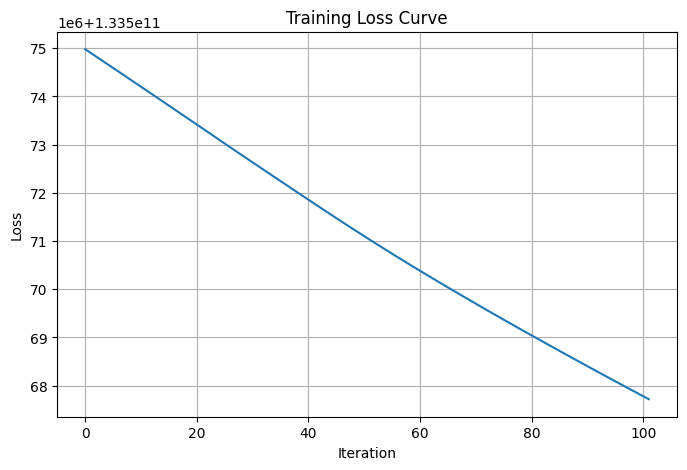

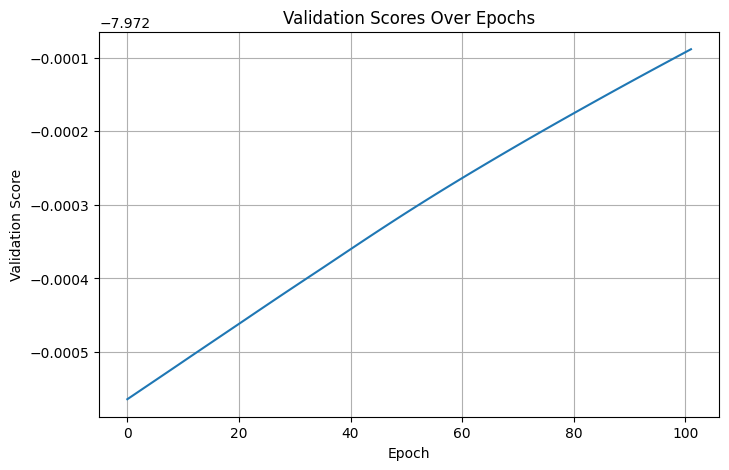

In [52]:
# ---- LOSS CURVE ----
plt.figure(figsize=(8, 5))
plt.plot(model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- VALIDATION SCORES ----
plt.figure(figsize=(8, 5))
plt.plot(model.validation_scores_)
plt.title("Validation Scores Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Score")
plt.grid(True)
plt.show()

In [53]:
y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("MAE:", mae)
print("MSE:", mse)

R² Score: -8.461346217490586
MAE: 511619.8369134736
MSE: 292690184336.3546


In [54]:
# Could be better, but not bad for a first try
results = pd.DataFrame(data={"y_test": y_test, "y_pred": y_pred}).sort_values(by="y_test")
results

,y_test,y_pred
397,1.600000e+05,14.275459
499,1.600000e+05,14.271739
554,1.670000e+05,14.287106
498,1.700000e+05,14.685516
377,1.850000e+05,14.242489
...,...,...
528,8.284375e+05,14.613540
575,8.777500e+05,14.859910
382,9.119203e+05,14.874533
414,9.202940e+05,14.608749
